Sample Jobs:
    Job_ID  Priority  Stage_1  Stage_2  Stage_3
0       1        51        7        8        1
1       2         7        4        8        6
2       3        21        8        3        9
3       4        73        5        6        1
4       5        39        7        5        3
5       6        18        3        2        7
6       7         4        7        8        4
7       8        89        8        6        9
8       9        60        5        2        3
9      10        14        4        5        5

FIFO Avg Cycle Time: 46.90, Throughput: 0.14
DPFOA Avg Cycle Time: 46.80, Throughput: 0.14


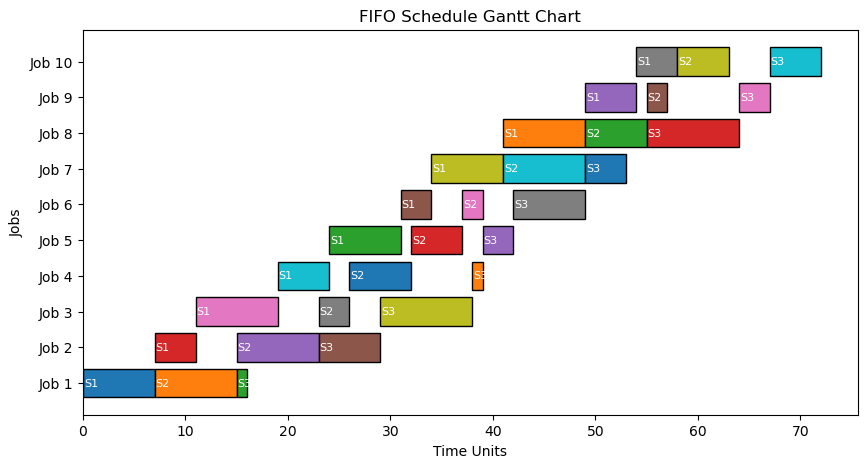

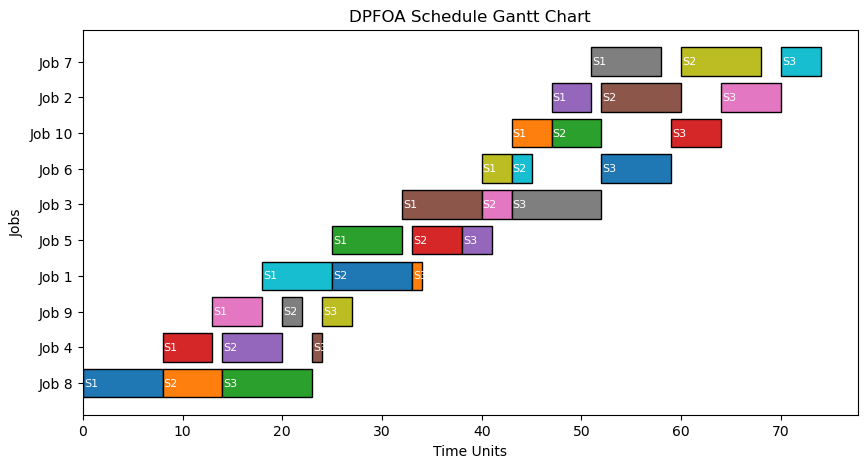

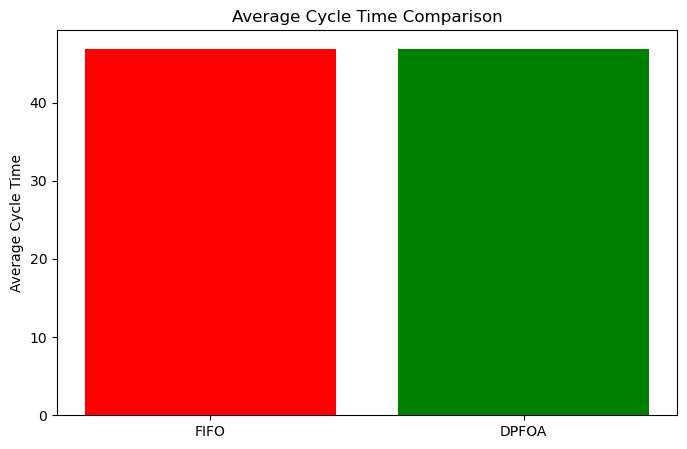

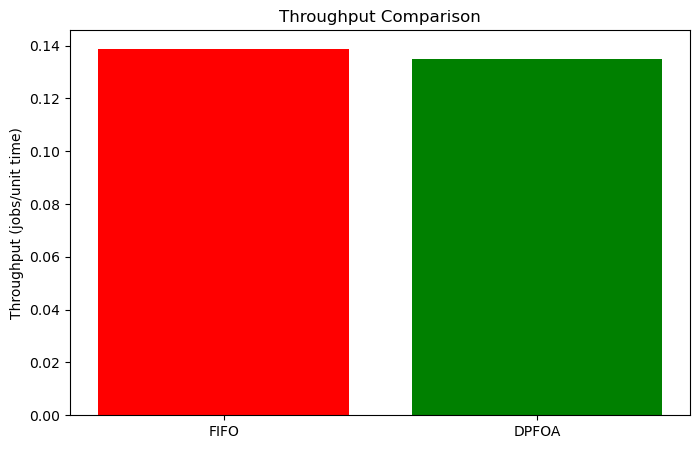

In [1]:
# DPFOA – Dynamic Workflow Optimization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Generate sample jobs
# -------------------------------
np.random.seed(42)
num_jobs = 10      # smaller for visualization
stages = 3

# Each job has processing times for each stage
jobs = pd.DataFrame({
    f"Stage_{i+1}": np.random.randint(1, 10, size=num_jobs)
    for i in range(stages)
})
jobs["Job_ID"] = range(1, num_jobs + 1)
jobs["Priority"] = np.random.randint(1, 100, size=num_jobs)  # higher is more urgent

jobs = jobs[["Job_ID", "Priority"] + [f"Stage_{i+1}" for i in range(stages)]]
print("Sample Jobs:\n", jobs)

# -------------------------------
# Step 2: Scheduling Functions
# -------------------------------
def fifo_schedule(jobs):
    completion_times = np.zeros((len(jobs), stages))
    start_times = np.zeros((len(jobs), stages))
    
    for idx, job in jobs.iterrows():
        for stage in range(stages):
            if stage == 0:
                start_times[idx, stage] = 0 if idx == 0 else completion_times[idx-1, stage]
            else:
                start_times[idx, stage] = max(completion_times[idx, stage-1], completion_times[idx-1, stage])
            completion_times[idx, stage] = start_times[idx, stage] + job[f"Stage_{stage+1}"]
    return start_times, completion_times

def dpfoa_schedule(jobs):
    jobs_sorted = jobs.sort_values(by="Priority", ascending=False).reset_index(drop=True)
    completion_times = np.zeros((len(jobs_sorted), stages))
    start_times = np.zeros((len(jobs_sorted), stages))
    
    for idx, job in jobs_sorted.iterrows():
        for stage in range(stages):
            if stage == 0:
                start_times[idx, stage] = 0 if idx == 0 else completion_times[idx-1, stage]
            else:
                start_times[idx, stage] = max(completion_times[idx, stage-1], completion_times[idx-1, stage])
            completion_times[idx, stage] = start_times[idx, stage] + job[f"Stage_{stage+1}"]
    return start_times, completion_times, jobs_sorted["Job_ID"]

# -------------------------------
# Step 3: Run simulations
# -------------------------------
fifo_start, fifo_ct = fifo_schedule(jobs)
dpfoa_start, dpfoa_ct, dpfoa_job_ids = dpfoa_schedule(jobs)

# Metrics
fifo_total_time = fifo_ct[-1, -1]
dpfoa_total_time = dpfoa_ct[-1, -1]

fifo_throughput = num_jobs / fifo_total_time
dpfoa_throughput = num_jobs / dpfoa_total_time

fifo_avg_cycle = fifo_ct[:, -1].mean()
dpfoa_avg_cycle = dpfoa_ct[:, -1].mean()

print(f"\nFIFO Avg Cycle Time: {fifo_avg_cycle:.2f}, Throughput: {fifo_throughput:.2f}")
print(f"DPFOA Avg Cycle Time: {dpfoa_avg_cycle:.2f}, Throughput: {dpfoa_throughput:.2f}")

# -------------------------------
# Step 4: Plot Gantt charts
# -------------------------------
def plot_gantt(start_times, completion_times, title, job_ids=None):
    fig, ax = plt.subplots(figsize=(10,5))
    for i in range(len(start_times)):
        for stage in range(stages):
            job_label = f"Job {i+1}" if job_ids is None else f"Job {job_ids.iloc[i]}"
            ax.barh(job_label, completion_times[i, stage]-start_times[i, stage], 
                    left=start_times[i, stage], edgecolor='black')
            ax.text(start_times[i, stage]+0.1, i, f"S{stage+1}", color='white', fontsize=8, va='center')
    ax.set_xlabel("Time Units")
    ax.set_ylabel("Jobs")
    ax.set_title(title)
    plt.show()

plot_gantt(fifo_start, fifo_ct, "FIFO Schedule Gantt Chart")
plot_gantt(dpfoa_start, dpfoa_ct, "DPFOA Schedule Gantt Chart", dpfoa_job_ids)

# -------------------------------
# Step 5: Bar Charts for Metrics
# -------------------------------
plt.figure(figsize=(8,5))
plt.bar(["FIFO", "DPFOA"], [fifo_avg_cycle, dpfoa_avg_cycle], color=['red','green'])
plt.ylabel("Average Cycle Time")
plt.title("Average Cycle Time Comparison")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(["FIFO", "DPFOA"], [fifo_throughput, dpfoa_throughput], color=['red','green'])
plt.ylabel("Throughput (jobs/unit time)")
plt.title("Throughput Comparison")
plt.show()
